# Doggy Shoe Size
## A simple ML model using OLS

In this scenario, you own a shop that sells harnesses for avalanche-rescue dogs, and you’ve recently expanded to also sell doggy boots. Customers all seem to pick the correct harness sizes but are constantly ordering doggy boots that are the wrong size. You know most customers buy harnesses and boots in the same transaction, which gives you an idea: perhaps you could approximate which doggy boots are the correct size, depending on the harness chosen. Then, you could warn customers if the boots they have selected are likely to be the correct size before they make the purchase.

Original Case: https://docs.microsoft.com/en-us/learn/modules/introduction-to-machine-learning/

In [1]:
# Load libraries
import pandas as pd
import statsmodels.formula.api as smf
import altair as alt
import joblib

In [2]:
# Load data
data = {
    'boot_size' : [ 39, 38, 37, 39, 38, 35, 37, 36, 35, 40, 
                    40, 36, 38, 39, 42, 42, 36, 36, 35, 41, 
                    42, 38, 37, 35, 40, 36, 35, 39, 41, 37, 
                    35, 41, 39, 41, 42, 42, 36, 37, 37, 39,
                    42, 35, 36, 41, 41, 41, 39, 39, 35, 39
 ],
    'harness_size': [ 58, 58, 52, 58, 57, 52, 55, 53, 49, 54,
                59, 56, 53, 58, 57, 58, 56, 51, 50, 59,
                59, 59, 55, 50, 55, 52, 53, 54, 61, 56,
                55, 60, 57, 56, 61, 58, 53, 57, 57, 55,
                60, 51, 52, 56, 55, 57, 58, 57, 51, 59
                ]
}
df = pd.DataFrame(data)
df.head(1)

,boot_size,harness_size
0,39,58


## Creating the model

In [3]:
# Create a simple OLS model
ols_model = smf.ols('boot_size ~ harness_size', df)

# Train the model to calculate the OLS line of fit
ols_fitted_model = ols_model.fit()

In [4]:
def ols_scatter(df, x, y):
    # scatter-plot data
    ax = df.plot(x=x, y=y, kind='scatter')
    x = df[x]

    # plot regression line on the same axes, set x-axis limits
    plot = ax.plot(x, ols_fitted_model.params[1] * x + ols_fitted_model.params[0]) #b1*x + b0
    return(plot)

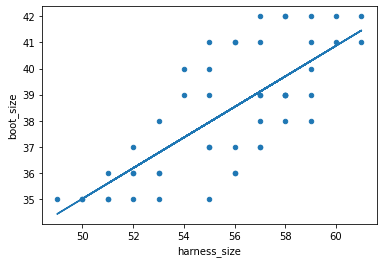

In [5]:
ols_scatter(df, 'harness_size', 'boot_size')

In [6]:
# Use the fitted OLS model to calculate the predicted shoe size based off harness size
# Notice how harness size of 50 is almost exactly 35 like the data point (since OLS line coincidentally passes through it)
ols_fitted_model.predict({'harness_size': [50, 55]}) 

0    35.015381
1    37.945008
dtype: float64

Now that a simple model has been created, we can begin building the model up and making it more complex. A good place to start is obtaining more data

## Adding complexity

In [7]:
# Read the data in via url
df = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/doggy-boot-harness.csv')

# Summary data
print(df.shape)
df.head(6)

(50, 4)


,boot_size,harness_size,sex,age_years
0,39,58,male,12.0
1,38,58,male,9.6
2,37,52,female,8.6
3,39,58,male,10.2
4,38,57,male,7.8
5,35,52,female,4.4


In [8]:
# Create an OLS model
ols_model = smf.ols('boot_size ~ harness_size + age_years + sex', df)

# Calculate trendline
ols_fitted_model = ols_model.fit()

In [9]:
# Predict boot_size given harness size, age, and sex
print('female: Actual ~ ', df.loc[2].boot_size, ' and ', df.loc[5].boot_size)
print(ols_fitted_model.predict({'harness_size': [52, 52],
                         'age_years': [8.6,4.4],
                         'sex': ['female', 'female']}))
print()
print('Male: Actual ~ ', df.loc[0].boot_size, ' and ', df.loc[1].boot_size)
print(ols_fitted_model.predict({'harness_size': [58, 58],
                         'age_years': [12,9.6],
                         'sex': ['male', 'male']}))

female: Actual ~  37  and  35
0    36.319232
1    36.361889
dtype: float64

Male: Actual ~  39  and  38
0    39.522490
1    39.546865
dtype: float64


Now that we've trained a model using available features, we can save this model to disk to prevent having to retrain the model for the next use

## Saving and using the Model

In [10]:
# Create a filename in a directory
model_filename = './avalanche_dog_boot_model_ols.pkl'

try:
    # Using the joblib library, save the model
    joblib.dump(ols_fitted_model, model_filename)
    print('Success - Model saved!')
except:
    print('An error occurred')

Success - Model saved!


In [11]:
# Load in the model
ols_model = joblib.load(model_filename)
ols_model.params

Intercept       2.511641
sex[T.male]    -0.673165
harness_size    0.651826
age_years      -0.010156
dtype: float64

In [12]:
a = ols_model.predict({'harness_size': 45,
                      'age_years': 3,
                      'sex': 'female'}).round(0)
for i in a:
    print(i)

32.0


In [13]:
h = 5
print(('The boots you selected might be TOO SMALL for a dog as big as yours. We suggest going ' \
                   f'with {h}'))

The boots you selected might be TOO SMALL for a dog as big as yours. We suggest going with 5


In [14]:
def size_checkout(selected_harness_size, selected_age_years, selected_sex, selected_boot_size):
    ''' 
    Given a user's inputs about their dog, return a message based on whether the selected boot_size matches that predicted 
    by the model.
    
    selected_harness_size: The size of the harness the customer wants to buy
    selected_age_years: The age of their dog
    selected_sex: The sex of their dog
    selected_boot_size: The size of the doggy boots the customer wants to buy
    '''
    
    # Start by loading in the model
    ols_model = joblib.load('./avalanche_dog_boot_model_ols.pkl')
    
    # Regress inputs on boot_size using OLS model
    predicted_boot_size = ols_model.predict({'harness_size': selected_harness_size,
                      'age_years': selected_age_years,
                      'sex': selected_sex}).round(0)
    
    # Create list to append outputs incase of multiple inputs
    res = []
    
    # Convert values to series which prevents int from not being subscriptable
    selected_harness_size = pd.Series(selected_harness_size)
    selected_age_years = pd.Series(selected_age_years)
    selected_sex = pd.Series(selected_sex)
    selected_boot_size = pd.Series(selected_boot_size)
    
    # Check if selected_boot_size matches the model's prediction and display message to user
    for i in range(len(predicted_boot_size)):
        if selected_boot_size[i] == int(predicted_boot_size[i]):
            res.append(f'Great choice! We think these boots will fit well')
        elif selected_boot_size[i] < int(predicted_boot_size[i]):
            res.append('The boots you selected might be TOO SMALL for a dog as big as yours. We suggest going '\
                   f'with size: {int(predicted_boot_size[i])}')
        elif selected_boot_size[i] > int(predicted_boot_size[i]):
            res.append('The boots you selected might be TOO BIG for a dog as small as yours. We suggest going '\
                   f'with size: {int(predicted_boot_size[i])}')
    return(res)

In [15]:
df.head(3)

,boot_size,harness_size,sex,age_years
0,39,58,male,12.0
1,38,58,male,9.6
2,37,52,female,8.6


In [16]:
# Test out the checkout function on integers
size_checkout(selected_harness_size=58, 
              selected_age_years=12, 
              selected_sex='male', 
              selected_boot_size=40)

['Great choice! We think these boots will fit well']

In [17]:
# Test out the checkout function on a list with one value
size_checkout(selected_harness_size=[58], 
              selected_age_years=[12], 
              selected_sex=['male'], 
              selected_boot_size=[40])

['Great choice! We think these boots will fit well']

In [18]:
# Test out the checkout function on a list with multiple values
size_checkout(selected_harness_size=[58,52], 
              selected_age_years=[12,8.6], 
              selected_sex=['male','female'], 
              selected_boot_size=[40,38])

['Great choice! We think these boots will fit well',
 'The boots you selected might be TOO BIG for a dog as small as yours. We suggest going with size: 36']